In [1]:
from keras.utils import HDF5Matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils import to_categorical
from keras import backend as K
import keras.callbacks as cb
from keras.models import load_model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv2D, MaxPool2D, Flatten, LeakyReLU, Concatenate, GlobalAveragePooling2D, UpSampling2D
from IPython.display import Image

import keras
import tensorflow
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd
import imageio
import cv2
import pprint

import src.model as my_model
import src.pcam_loader as data
import src.adaptive_model as am

Using TensorFlow backend.


# Show if tensorflow can run with GPU
# Run tensorflow keras on multiple core

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# config = tf.ConfigProto(device_count={"CPU": 8})
# tensorflow.compat.v1.keras.backend.set_session(tf.Session(config=config))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 739752586173594237
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4854028697
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17799861541477197685
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5"
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5



## Load pcam data

In [3]:
# Load data from /User/Username/.keras/datasets/pcam
dataset = data.load_data()
x_train, y_train, meta_train =  dataset[0]
x_valid, y_valid, meta_valid =  dataset[1]
x_test, y_test, meta_test =  dataset[2]

C:\Users\matho\Anaconda3\lib\site-packages\keras\utils\io_utils.py:60: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(datapath)


In [4]:
y_train = np.array(y_train[:])
y_train = y_train.reshape(-1, 1)
y_valid = np.array(y_valid[:])
y_valid = y_valid.reshape(-1, 1)
y_test = np.array(y_test[:])
y_test = y_test.reshape(-1, 1)

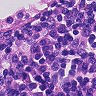

In [5]:
# Save data into png format and visualize image
# imageio.imwrite('image.png', )
Image(filename='./data/image.png') 

In [6]:
print(meta_train.head(5), '\n')
print(meta_train.info())

# Shape of train, valid and test input are the same, don't need to preprocess
print('\n' + 'Shape of train', x_train.shape,  len(y_train), y_train.shape)
print('Shape of valid', x_valid.shape,  len(y_valid), y_valid.shape)
print('Shape of test', x_test.shape, len(y_test), y_test.shape)


   Unnamed: 0  coord_y  coord_x  tumor_patch  center_tumor_patch  \
0           0    63104    43648        False               False   
1           1   148544    74048         True                True   
2           2    64192    78912         True                True   
3           3    98048    72128         True                True   
4           4    27264    50688        False               False   

                           wsi  
0   camelyon16_train_tumor_104  
1   camelyon16_train_tumor_003  
2   camelyon16_train_tumor_089  
3   camelyon16_train_tumor_004  
4  camelyon16_train_normal_118   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262144 entries, 0 to 262143
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Unnamed: 0          262144 non-null  int64 
 1   coord_y             262144 non-null  int64 
 2   coord_x             262144 non-null  int64 
 3   tumor_patch         262144 non-

# Build model

In [7]:
batch_size = 64
epochs = 10
num_classes = 2
shape = (96, 96, 3)

## Backpropagation

In [ ]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_backpropagation764.h5'

# layers = am.unet_layer(input_layer, 7, 16) 
# layers = am.unet_layer(input_layer, 5, 16) 
# layers = am.unet_layer(input_layer, 3, 16) 

# layers = am.unet_layer(input_layer, 7, 32)
# Test loss: 0.4615268358029425 Accuracy: 0.8088379 Precision: 0.8088379 Recall: 0.8088379 TruePositives: 26504.0 F1_score 0.8088378406250031
# layers = am.unet_layer(input_layer, 5, 32) 
# Test loss: 0.5212567583439522 Accuracy: 0.78674316 Precision: 0.78674316 Recall: 0.78674316 TruePositives: 25780.0 F1_score 0.7867430951221921 
# layers = am.unet_layer(input_layer, 3, 32)
# Test loss: 0.43483126438513864 Accuracy: 0.8204346 Precision: 0.8204346 Recall: 0.8204346 TruePositives: 26884.0 F1_score 0.8204345021499818 

layers = am.unet_layer(input_layer, 7, 64) 
# layers = am.unet_layer(input_layer, 5, 64) 
# layers = am.unet_layer(input_layer, 3, 64) 

# Use Unet architecture as main model
output_layer = am.unet_model(layers)

# Define model 
model = am.define_model(input_layer, output_layer)

# [test 78,8% | test 80,8% val_accuracy: 80% valid 96,36% | ]

## Autoencoder

In [8]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_autoencoder332.h5'

# layers = am.encoder_layer(input_layer, 7, 16) 
# layers = am.encoder_layer(input_layer, 5, 16) 
# layers = am.encoder_layer(input_layer, 3, 16) 

# layers = am.encoder_layer(input_layer, 7, 32) 
# Test loss: 0.5600800448955852 Accuracy: 0.73861694 Precision: 0.73861694 Recall: 0.73861694 TruePositives: 24203.0 F1_score 0.7386169021856822
# layers = am.encoder_layer(input_layer, 5, 32) 
# Test loss: 0.6415949882357381 Accuracy: 0.7125244140625 Precision: 0.7125244140625 Recall: 0.7125244140625 TruePositives: 2600915.25 F1_score 0.7125243640625035 
# layers = am.encoder_layer(input_layer, 3, 32)
# Test loss: 1.0000710187887307 Accuracy: 0.70782470703125 Precision: 0.70782470703125 Recall: 0.70782470703125 TruePositives: 2728194.75 F1_score 0.7078246570312535

# layers = am.encoder_layer(input_layer, 7, 64) 
# layers = am.encoder_layer(input_layer, 5, 64) 
# layers = am.encoder_layer(input_layer, 3, 64) 

# Use Unet architecture as main model
output_layer = am.unet_model(layers)

# Define model 
model = am.define_model(input_layer, output_layer)

# [test 67% valid 96,97% | test 80,524% val_accuracy 86,5% accuracy 95,84% | ]

## Gabor kernels

In [ ]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_gabor964.h5'

# layers = am.gabor_layer(input_layer, 9, 16) 
# layers = am.gabor_layer(input_layer, 7, 16) 
# layers = am.gabor_layer(input_layer, 5, 16) 

# layers = am.gabor_layer(input_layer, 9, 32) 
# Test loss: 0.5573686596835614 Accuracy: 0.7546997 Precision: 0.7546997 Recall: 0.7546997 TruePositives: 24730.0 F1_score 0.7546996915841093
# layers = am.gabor_layer(input_layer, 7, 32)
# Test loss: 0.6931897189933807 Accuracy: 0.5002136 Precision: 0.5002136 Recall: 0.5002136 TruePositives: 16391.0 F1_score 0.5002136009746224 
# layers = am.gabor_layer(input_layer, 5, 32)
# Test loss: 0.5465048969927011 Accuracy: 0.77923584 Precision: 0.77923584 Recall: 0.77923584 TruePositives: 25534.0 F1_score 0.7792357850630567 

# layers = am.gabor_layer(input_layer, 9, 64) 
# layers = am.gabor_layer(input_layer, 7, 64) 
# layers = am.gabor_layer(input_layer, 5, 64) 

# Use Unet architecture as main model
output_layer = am.unet_model(layers)

# Define model 
model = am.define_model(input_layer, output_layer)

# Add filters from gabor function
model.layers[1].set_weights(am.gabor_filter(model))

## Transfer learning

In [ ]:
from keras.applications import MobileNet
model_name = 'adaptive_transfer.h5'

# Use ImageNet as first 'layers'
base_model=MobileNet(weights='imagenet',include_top=False) 
layer = base_model.output

# Use Unet architecture as main model
output_layer = am.unet_model(layer)

# Define model 
model = am.define_model(input_layer, output_layer)

# x=GlobalAveragePooling2D()(x)
# x=Dense(1024,activation='relu')(x) 
# x=Dense(1024,activation='relu')(x) #dense layer 2
# x=Dense(512,activation='relu')(x) #dense layer 3
# preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

## Own Metrics

In [9]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    result = true_positives / (possible_positives + K.epsilon())
    return result

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    result = true_positives / (predicted_positives + K.epsilon())
    return result


def accuracy(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    negative_positives = K.sum(K.round(K.clip(y_true * y_pred, 1, 0)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    result = true_positives + negative_positives
    result = result / result + possible_positives + predicted_positives
    return result

# def f1_score(y_true, y_pred):
#     precision_result = precision(y_true, y_pred)
#     recall_result = recall(y_true, y_pred)
#     return 2*((precision_result*recall_result)/(precision_result+recall_result+K.epsilon()))


### Compile and train the model

In [12]:
callbacks = [
    cb.callbacks.ModelCheckpoint(model_name, save_best_only=True)
#     cb.callbacks.EarlyStopping(monitor = 'val_loss'),
#     cb.callbacks.CSVLogger('model.csv', separator=',', append=False),
#     cb.tensorboard_v1.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
]

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=[
                       precision,
                       recall,
                       'accuracy',
                       tensorflow.keras.metrics.TruePositives(),
                       tensorflow.keras.metrics.FalsePositives(),
                       tensorflow.keras.metrics.FalseNegatives()
                      ])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 96, 96, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 96, 32)   9248        dropout_1[0][0]                  
____________________________________________________________________________________________

In [13]:
history = model.fit(
    x_train,
    to_categorical(y_train),
    # batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_valid, to_categorical(y_valid)),
    shuffle='batch',
    callbacks=callbacks,
    use_multiprocessing=True, 
    workers=8
)

Train on 262144 samples, validate on 32768 samples
Epoch 1/10
262144/262144 [==============================] - 812s 3ms/step - loss: 0.1902 - precision: 0.9267 - recall: 0.9267 - accuracy: 0.9267 - true_positives_1: 121335.5312 - false_positives_1: 9752.4531 - false_negatives_1: 9752.4531 - val_loss: 0.6084 - val_precision: 0.6830 - val_recall: 0.6830 - val_accuracy: 0.6830 - val_true_positives_1: 254122.2812 - val_false_positives_1: 24421.7852 - val_false_negatives_1: 24421.7852
Epoch 2/10
262144/262144 [==============================] - 804s 3ms/step - loss: 0.1751 - precision: 0.9323 - recall: 0.9323 - accuracy: 0.9323 - true_positives_1: 387475.4688 - false_positives_1: 38524.2773 - false_negatives_1: 38524.2773 - val_loss: 0.5097 - val_precision: 0.7852 - val_recall: 0.7852 - val_accuracy: 0.7852 - val_true_positives_1: 522631.6875 - val_false_positives_1: 50824.1797 - val_false_negatives_1: 50824.1797
Epoch 3/10
262144/262144 [==============================] - 804s 3ms/step - los

In [14]:
model.save('eop_' + model_name)

# Evaluate the model

In [15]:
def f1_score_fun(precision, recall):
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
test_eval = model.evaluate(x_test, to_categorical(y_test), verbose=0)
f1_score = f1_score_fun(test_eval[2], test_eval[3])

In [17]:
print('Test loss:', test_eval[0],end=' ')
print('Accuracy:', test_eval[1],end=' ')
print('Precision:', test_eval[2],end=' ')
print('Recall:', test_eval[3],end=' ')
print('TruePositives:', test_eval[4],end=' ')
print('F1_score', f1_score,end=' ')

Test loss: 1.0000710187887307 Accuracy: 0.70782470703125 Precision: 0.70782470703125 Recall: 0.70782470703125 TruePositives: 2728194.75 F1_score 0.7078246570312535 

In [18]:
y_pred = model.predict(x_test, verbose=0, workers=8, use_multiprocessing=True)

In [20]:
print('My precision', precision(to_categorical(y_test), y_pred))
print('My recall', recall(to_categorical(y_test), y_pred))
print('My accuracy', accuracy(to_categorical(y_test), y_pred))

My precision tf.Tensor(0.7078247, shape=(), dtype=float32)
My recall tf.Tensor(0.7078247, shape=(), dtype=float32)
My accuracy tf.Tensor(65537.0, shape=(), dtype=float32)


In [21]:
# load model
# custom_objects = {}
# custom_objects["tensorflow.keras.metrics.Precision()"] = tensorflow.keras.metrics.Precision()
# model = tf.keras.models.load_model('eop_' + model_name, custom_objects=custom_objects)

custom_objects = {}
custom_objects["precision"] = precision
custom_objects["recall"] = recall
custom_objects["tensorflow.keras.metrics.TruePositives"] = tensorflow.keras.metrics.TruePositives()
custom_objects["tensorflow.keras.metrics.FalsePositives"] = tensorflow.keras.metrics.FalsePositives()
custom_objects["tensorflow.keras.metrics.FalseNegatives"] = tensorflow.keras.metrics.FalseNegatives()
loaded_model = tf.keras.models.load_model('eop_' + model_name, custom_objects=custom_objects)

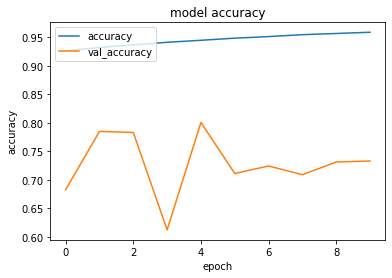

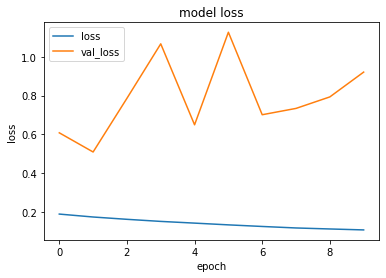

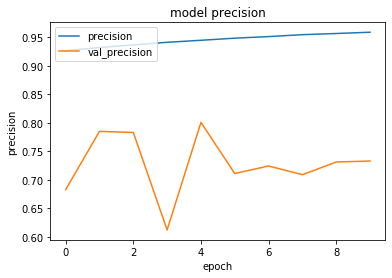

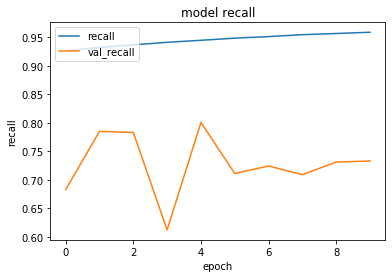

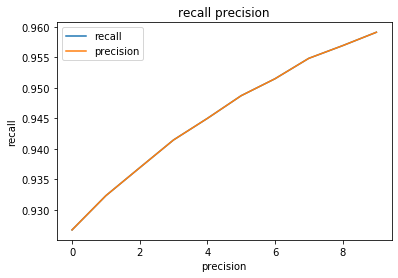

In [24]:
import matplotlib.pyplot as plt
# print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['precision', 'val_precision'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['recall', 'val_recall'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['precision'])
plt.title('recall precision')
plt.ylabel('recall')
plt.xlabel('precision')
plt.legend(['recall', 'precision'], loc='upper left')
plt.show()